In [1]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.8 MB/s eta 0:00:00


In [2]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def process_df():
  """
    Reads in the gameweek information for all players in the 2024-25 FPL season

    Sets their gameweek 1 value as their permanent value
  """
  master_df = None
  for i in range(1, 32):
    url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw" + str(i) + ".csv"
    df = pd.read_csv(url)
    df = df[['name', 'position', 'team', 'value', 'total_points']]
    df = df.groupby('name', as_index=False).agg({'position': 'first',
                                                 'team': 'first',
                                                 'value': 'first',
                                                 'total_points': 'sum'})
    df = df.rename(columns={'total_points': f'gw_{i}_points'})
    if master_df is None:
      master_df = df
    else:
      temp = pd.merge(master_df,
                      df[['name', 'position', 'team', 'value', f'gw_{i}_points']],
                      on=['name', 'position'],
                      how='outer',
                      suffixes=('', '_new'))
      temp['team'] = temp['team'].fillna(temp['team_new'])
      temp['value'] = temp['value'].fillna(temp['value_new'])
      temp = temp.drop(columns=['team_new', 'value_new'])
      master_df = temp
  master_df = master_df.fillna(0);
  return master_df

In [4]:
master_df = process_df()

In [5]:
master_df.head()

,name,position,team,value,gw_1_points,gw_2_points,gw_3_points,gw_4_points,gw_5_points,gw_6_points,...,gw_22_points,gw_23_points,gw_24_points,gw_25_points,gw_26_points,gw_27_points,gw_28_points,gw_29_points,gw_30_points,gw_31_points
0,Aaron Anselmino,DEF,Chelsea,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Aaron Cresswell,DEF,West Ham,40.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,6.0,9.0,2.0,0.0,1.0,0
2,Aaron Hickey,DEF,Brentford,45.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Aaron Ramsdale,GK,Arsenal,45.0,0.0,0.0,2.0,3.0,3.0,2.0,...,1.0,0.0,3.0,2.0,1.0,2.0,2.0,1.0,2.0,2
4,Aaron Wan-Bissaka,DEF,West Ham,45.0,0.0,1.0,1.0,2.0,1.0,2.0,...,1.0,2.0,-1.0,2.0,12.0,7.0,2.0,2.0,2.0,1


In [6]:
def process_df_prices():
  """
    Reads in the gameweek information for all players in the 2024-25 FPL season

    Player values in each week are recorded, but players who were not present at
    the beginning of the season are dropped, as they don't have values until
    later gameweek.s
  """
  master_df = None
  for i in range(1, 32):
    url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw" + str(i) + ".csv"
    df = pd.read_csv(url)
    df = df[['name', 'position', 'team', 'value', 'total_points']]
    df = df.groupby('name', as_index=False).agg({'position': 'first',
                                                 'team': 'first',
                                                 'value': 'first',
                                                 'total_points': 'sum'})
    df = df.rename(columns={'value': f'gw_{i}_value'})
    df = df.rename(columns={'total_points': f'gw_{i}_points'})
    if master_df is None:
      master_df = df
    else:
      temp = pd.merge(master_df,
                      df[['name', 'position', 'team', f'gw_{i}_value', f'gw_{i}_points']],
                      on=['name', 'position'],
                      how='outer',
                      suffixes=('', '_new'))
      temp['team'] = temp['team'].fillna(temp['team_new'])
      temp = temp.drop(columns=['team_new'])
      master_df = temp
    points_cols = [col for col in master_df.columns if col.startswith("gw_") and col.endswith("_points")]
    master_df[points_cols] = master_df[points_cols].fillna(0)
    value_cols = [col for col in master_df.columns if col.startswith("gw_") and col.endswith("_value")]
    master_df[value_cols] = master_df[value_cols].ffill(axis=1)
    master_df = master_df.dropna()
  return master_df

In [7]:
master_df_prices = process_df_prices()

In [8]:
master_df_prices.head()

,name,position,team,gw_1_value,gw_1_points,gw_2_value,gw_2_points,gw_3_value,gw_3_points,gw_4_value,...,gw_27_value,gw_27_points,gw_28_value,gw_28_points,gw_29_value,gw_29_points,gw_30_value,gw_30_points,gw_31_value,gw_31_points
1,Aaron Cresswell,DEF,West Ham,40.0,0.0,40.0,1.0,40.0,0.0,40.0,...,39.0,9.0,39.0,2.0,39.0,0.0,39.0,1.0,39.0,0
2,Aaron Hickey,DEF,Brentford,45.0,0.0,45.0,0.0,45.0,0.0,44.0,...,43.0,0.0,43.0,0.0,43.0,0.0,43.0,0.0,43.0,0
3,Aaron Ramsdale,GK,Arsenal,45.0,0.0,45.0,0.0,44.0,2.0,44.0,...,44.0,2.0,44.0,2.0,44.0,1.0,44.0,2.0,44.0,2
4,Aaron Wan-Bissaka,DEF,West Ham,45.0,0.0,45.0,1.0,45.0,1.0,45.0,...,44.0,7.0,44.0,2.0,45.0,2.0,45.0,2.0,45.0,1
5,Abdoulaye Doucouré,MID,Everton,55.0,2.0,55.0,1.0,54.0,1.0,53.0,...,51.0,0.0,51.0,2.0,51.0,2.0,51.0,2.0,51.0,2


In [66]:
def process_df_single_week(i):
  """
    Reads in the gameweek information for just one week
  """
  url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw" + str(i) + ".csv"
  df = pd.read_csv(url)
  df = df[['name', 'position', 'team', 'value', 'total_points']]
  df = df.groupby('name', as_index=False).agg({'position': 'first',
                                                'team': 'first',
                                                'value': 'first',
                                                'total_points': 'sum'})
  return df

In [70]:
def lin_opt_single_week(df):
  """
    This takes in a dataframe which has a list of players, their value in a
    specific gameweek, and their points scored in that gameweek.

    This returns a dataframe, starting_df, with all the players as rows,
    a column labeled gw_j, marked 2 if the player was the captain, 1 if the
    player started, 0 if the player did not start,
    and another dataframe, squad_df, with all the players as rows,
    marked 1 if the player was in the squad, and 0 if the player was not
  """
  model = pulp.LpProblem("FPL_Single_Week_Opt", pulp.LpMaximize)
  x = pulp.LpVariable.dicts("x", df.index, cat="Binary")
  y = pulp.LpVariable.dicts("y", df.index, cat="Binary")
  cap = pulp.LpVariable.dicts("cap", df.index, cat="Binary")

  model += pulp.lpSum(df.loc[i, 'total_points'] * (y[i] + cap[i]) for i in df.index), "Total Points"
  model += pulp.lpSum(x[i] for i in df.index) == 15, 'Squad Size'
  model += pulp.lpSum(df.loc[i, 'value'] * x[i] for i in df.index) <= 1000, 'Total Value'

  model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'position'] == "GK") == 2
  model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'position'] == "DEF") == 5
  model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'position'] == "MID") == 5
  model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'position'] == "FWD") == 3

  teams = df['team'].unique()
  for team in teams:
    model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'team'] == team) <= 3

  model += pulp.lpSum(y[i] for i in df.index) == 11, "Starting Lineup Size"

  model += pulp.lpSum(y[i] for i in df.index if df.loc[i, 'position'] == "GK") == 1
  model += pulp.lpSum(y[i] for i in df.index if df.loc[i, 'position'] == "DEF") >= 3
  model += pulp.lpSum(y[i] for i in df.index if df.loc[i, 'position'] == "MID") >= 2
  model += pulp.lpSum(y[i] for i in df.index if df.loc[i, 'position'] == "FWD") >= 1

  model += pulp.lpSum(cap[i] for i in df.index) == 1

  for i in df.index:
    model += y[i] <= x[i]
    model += cap[i] <= y[i]
  model.solve()

  squad_df = df[['name', 'position', 'team']].copy()
  squad_df['squad'] = [int(x[i].varValue) for i in df.index]

  starting_df = df[['name', 'position', 'team']].copy()
  starting_df['starting'] = [
    2 if cap[i].varValue == 1 else
    1 if y[i].varValue == 1 else
    0 for i in df.index
  ]

  return starting_df, squad_df

In [71]:
starting_dfs = []
squad_dfs = []

for i in range(1, 32):
  df = process_df_single_week(i)
  gw_starting, gw_squad = lin_opt_single_week(df)
  gw_starting.rename(columns={'starting':f'gw_{i}'}, inplace=True)
  gw_squad.rename(columns={'squad':f'gw_{i}'}, inplace=True)
  starting_dfs.append(gw_starting.set_index(['name', 'position', 'team']))
  squad_dfs.append(gw_squad.set_index(['name', 'position', 'team']))

starting = pd.concat(starting_dfs, axis=1)
squad = pd.concat(squad_dfs, axis=1)
starting = starting.reset_index()
squad = squad.reset_index()

In [74]:
starting = starting.fillna(0)
squad = squad.fillna(0)

In [77]:
gw_columns = [col for col in squad.columns if col.startswith('gw_')]

squad['total_apps'] = squad[gw_columns].sum(axis=1)
starting['total_starts'] = (starting[gw_columns] >= 1).sum(axis=1)

In [111]:
squad[['name', 'position', 'team', 'total_apps']].sort_values(by='total_apps', ascending=False).head(6)

,name,position,team,total_apps
431,Mohamed Salah,MID,Liverpool,12.0
21,Alexander Isak,FWD,Newcastle,9.0
110,Cole Palmer,MID,Chelsea,8.0
572,Trent Alexander-Arnold,DEF,Liverpool,6.0
470,Ollie Watkins,FWD,Aston Villa,6.0
103,Chris Wood,FWD,Nott'm Forest,6.0


In [113]:
starting[['name', 'position', 'team', 'total_starts']].sort_values(by='total_starts', ascending=False).head(4)

,name,position,team,total_starts
431,Mohamed Salah,MID,Liverpool,12
110,Cole Palmer,MID,Chelsea,8
21,Alexander Isak,FWD,Newcastle,7
470,Ollie Watkins,FWD,Aston Villa,6


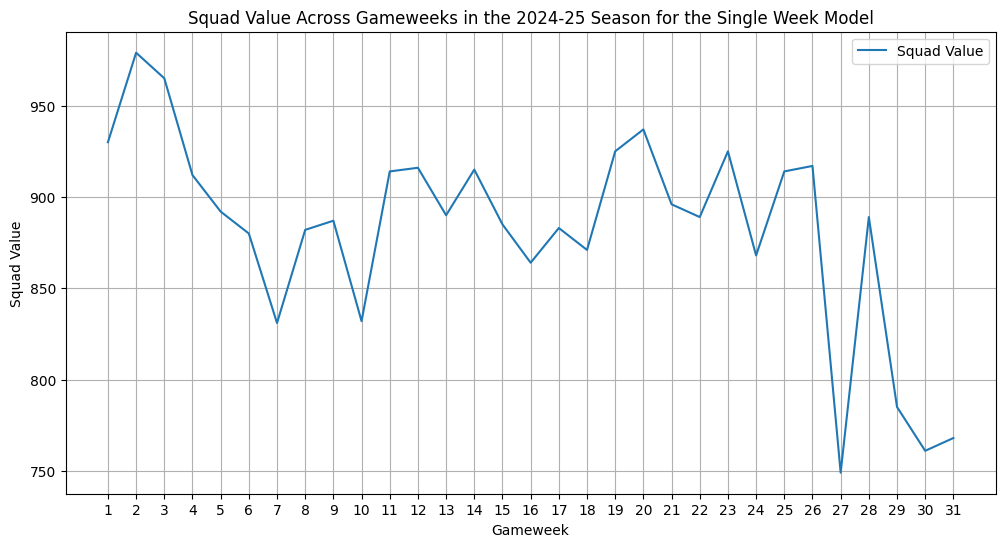

In [85]:
weeks = range(1,32)
squad_values = []
for gw in weeks:
  df = process_df_single_week(gw)
  squad_in_gw = squad[["name", f"gw_{gw}"]].copy()
  squad_in_gw = squad_in_gw.merge(
    df[["name", "value"]],
    on="name",
    how="left"
  )
  squad_in_gw["value"] = squad_in_gw[f"gw_{gw}"] * squad_in_gw["value"]
  total_value = squad_in_gw["value"].sum()
  squad_values.append(total_value)

plt.figure(figsize=(12, 6))
plt.plot(weeks, squad_values, label="Squad Value")

plt.xlabel("Gameweek")
plt.ylabel("Squad Value")
plt.title("Squad Value Across Gameweeks in the 2024-25 Season for the Single Week Model")
plt.xticks(weeks)
plt.grid(True)
plt.legend()
plt.show()

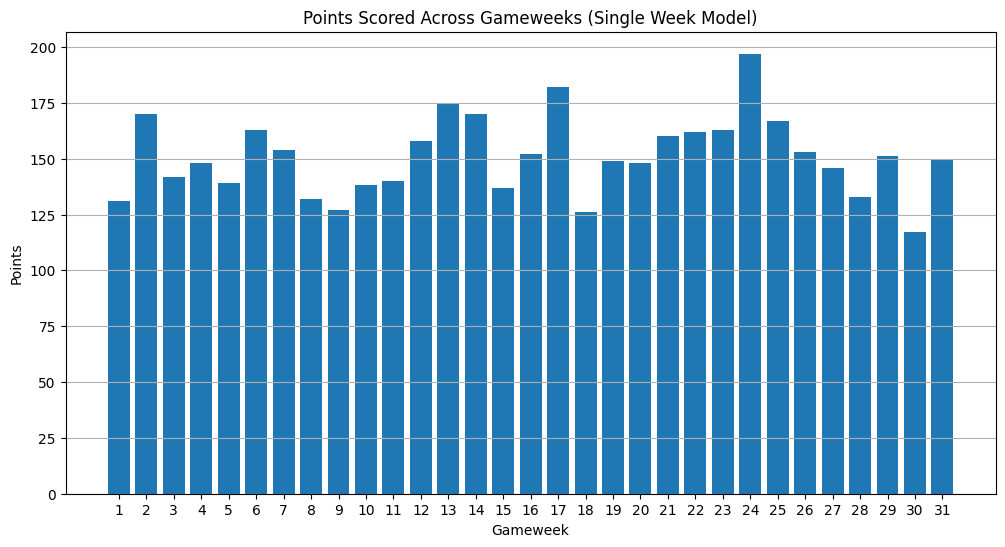

In [140]:
points_per_week = []
for gw in weeks:
  df = process_df_single_week(gw)
  starting_in_gw = starting[["name", f"gw_{gw}"]].copy()
  starting_in_gw = starting_in_gw.merge(
      df[["name", "total_points"]],
      on="name",
      how="left"
  )
  starting_in_gw["points"] = starting_in_gw[f"gw_{gw}"] * starting_in_gw["total_points"]
  total_points = starting_in_gw["points"].sum()
  points_per_week.append(total_points)

plt.figure(figsize=(12, 6))
plt.bar(weeks, points_per_week)

plt.xlabel("Gameweek")
plt.ylabel("Points")
plt.title("Points Scored Across Gameweeks (Single Week Model)")
plt.xticks(weeks)
plt.grid(axis='y')
plt.show()

In [141]:
print("Points with Single Week Model: " + str(sum(points_per_week)))

Points with Single Week Model: 4680.0


In [25]:
def lin_opt_no_transfers(df):
  model = pulp.LpProblem("FPL_All_Weeks_No_Transfers", pulp.LpMaximize)
  x = pulp.LpVariable.dicts("x", df.index, cat="Binary")
  weeks = range(1, 32)
  y = {}
  cap = {}
  for j in weeks:
    y[j] = pulp.LpVariable.dicts(f"y_{j}", df.index, cat="Binary")
    cap[j] = pulp.LpVariable.dicts(f"cap_{j}", df.index, cat="Binary")

  model += pulp.lpSum(pulp.lpSum(df.loc[i, f'gw_{j}_points'] * (y[j][i] + cap[j][i]) for i in df.index) for j in weeks)

  model += pulp.lpSum(x[i] for i in df.index) == 15, 'Squad Size'
  model += pulp.lpSum(df.loc[i, 'value'] * x[i] for i in df.index) <= 1000, 'Total Value'

  model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'position'] == "GK") == 2
  model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'position'] == "DEF") == 5
  model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'position'] == "MID") == 5
  model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'position'] == "FWD") == 3

  teams = df['team'].unique()
  for team in teams:
    model += pulp.lpSum(x[i] for i in df.index if df.loc[i, 'team'] == team) <= 3

  for j in weeks:
    model += pulp.lpSum(y[j][i] for i in df.index) == 11
    model += pulp.lpSum(y[j][i] for i in df.index if df.loc[i, 'position'] == "GK") == 1
    model += pulp.lpSum(y[j][i] for i in df.index if df.loc[i, 'position'] == "DEF") >= 3
    model += pulp.lpSum(y[j][i] for i in df.index if df.loc[i, 'position'] == "MID") >= 2
    model += pulp.lpSum(y[j][i] for i in df.index if df.loc[i, 'position'] == "FWD") >= 1
    model += pulp.lpSum(cap[j][i] for i in df.index) == 1

    for i in df.index:
      model += y[j][i] <= x[i]
      model += cap[j][i] <= y[j][i]
  model.solve()
  squad_df = df.loc[[x[i].varValue == 1 for i in df.index], ['name', 'position', 'team']].copy()

  for j in weeks:
    gw_status = []
    for i in squad_df.index:
      if cap[j][i].varValue == 1:
        gw_status.append(2)
      elif y[j][i].varValue == 1:
        gw_status.append(1)
      else:
        gw_status.append(0)
    squad_df[f'gw_{j}'] = gw_status

  return squad_df

In [26]:
squad_no_transfers = lin_opt_no_transfers(master_df)

In [27]:
squad_no_transfers['total_starts'] = (squad_no_transfers[gw_columns] >= 1).sum(axis=1)

In [149]:
squad_no_transfers[['name', 'position', 'team', 'total_starts']]

,name,position,team,total_starts
25,Alexander Isak,FWD,Newcastle,21
46,André Onana,GK,Man Utd,15
102,Bryan Mbeumo,MID,Brentford,30
136,Chris Wood,FWD,Nott'm Forest,26
145,Cole Palmer,MID,Chelsea,23
166,Daniel Muñoz,DEF,Crystal Palace,22
388,Jordan Pickford,GK,Everton,16
407,Joško Gvardiol,DEF,Man City,18
416,Justin Kluivert,MID,Bournemouth,23
477,Luis Díaz,MID,Liverpool,22


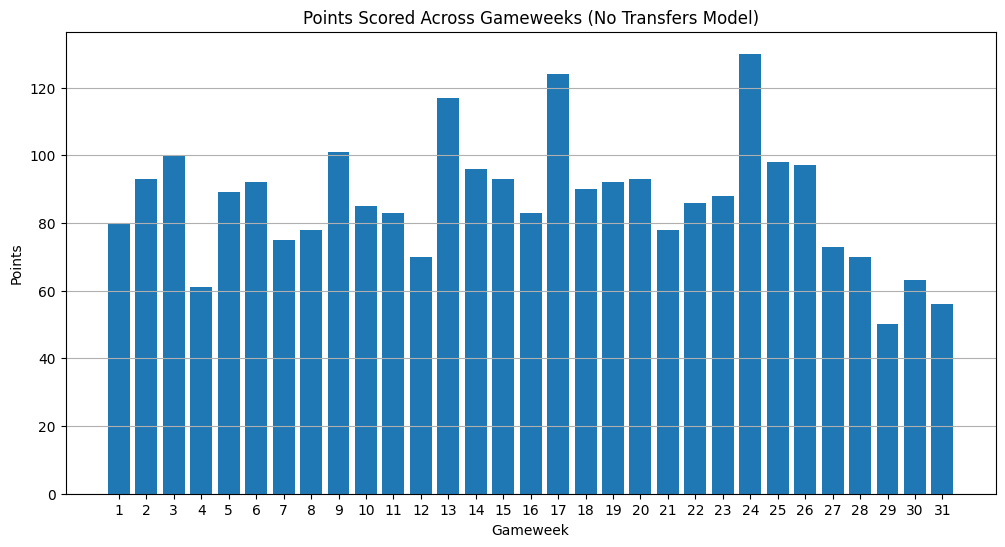

In [137]:
points_per_week = []
for gw in weeks:
    starting_in_gw = squad_no_transfers[["name", f"gw_{gw}"]].copy()
    starting_in_gw = starting_in_gw.merge(
        master_df[["name", f"gw_{gw}_points"]],
        on="name",
        how="left"
    )
    starting_in_gw["points"] = starting_in_gw[f"gw_{gw}"] * starting_in_gw[f"gw_{gw}_points"]
    total_points = starting_in_gw["points"].sum()
    points_per_week.append(total_points)

plt.figure(figsize=(12, 6))
plt.bar(weeks, points_per_week)

plt.xlabel("Gameweek")
plt.ylabel("Points")
plt.title("Points Scored Across Gameweeks (No Transfers Model)")
plt.xticks(weeks)
plt.grid(axis='y')
plt.show()

In [139]:
print("Points with No Transfers: " + str(sum(points_per_week)))

Points with No Transfers: 2684.0


In [132]:
def lin_opt_transfers(df):
  model = pulp.LpProblem("FPL_All_Weeks_Transfers", pulp.LpMaximize)
  weeks = range(1, 32)
  players = list(df.index)

  x = {j: pulp.LpVariable.dicts(f"x_{j}", players, cat="Binary") for j in weeks}
  y = {j: pulp.LpVariable.dicts(f"y_{j}", players, cat="Binary") for j in weeks}
  cap = {j: pulp.LpVariable.dicts(f"cap_{j}", players, cat="Binary") for j in weeks}
  u = {j: pulp.LpVariable.dicts(f"u_{j}", players, cat="Binary") for j in range(2, 32)}
  p = {j: pulp.LpVariable(f"p_{j}", lowBound=0, cat="Integer") for j in range(2, 32)}

  model += (pulp.lpSum(pulp.lpSum(df.loc[i, f'gw_{j}_points'] * (y[j][i] + cap[j][i]) for i in players) for j in weeks)
  - pulp.lpSum(4 * p[j] for j in range(2, 32))), "Total_Points"

  for j in weeks:
    model += pulp.lpSum(x[j][i] for i in players) == 15
    model += pulp.lpSum(df.loc[i, 'value'] * x[j][i] for i in df.index) <= 1000

    model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'position'] == "GK") == 2
    model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'position'] == "DEF") == 5
    model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'position'] == "MID") == 5
    model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'position'] == "FWD") == 3
    teams = df['team'].unique()
    for team in teams:
      model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'team'] == team) <= 3

    model += pulp.lpSum(y[j][i] for i in players) == 11
    model += pulp.lpSum(y[j][i] for i in players if df.loc[i, 'position'] == "GK") == 1
    model += pulp.lpSum(y[j][i] for i in players if df.loc[i, 'position'] == "DEF") >= 3
    model += pulp.lpSum(y[j][i] for i in players if df.loc[i, 'position'] == "MID") >= 2
    model += pulp.lpSum(y[j][i] for i in players if df.loc[i, 'position'] == "FWD") >= 1
    model += pulp.lpSum(cap[j][i] for i in players) == 1

    for i in players:
      model += y[j][i] <= x[j][i]
      model += cap[j][i] <= y[j][i]

  for j in range(2, 32):
    for i in players:
      model += u[j][i] >= x[j][i] - x[j-1][i]
      model += u[j][i] <= x[j][i]
      model += u[j][i] <= 1 - x[j-1][i]
    model += p[j] >= pulp.lpSum(u[j][i] for i in players) - 1

  model.solve()

  players_in_any_squad = [i for i in players if any(x[j][i].varValue == 1 for j in weeks)]
  base_cols = df.loc[players_in_any_squad, ['name', 'position', 'team']].copy()

  squad_df = base_cols.copy()
  starting_df = base_cols.copy()

  for j in weeks:
    squad_col = []
    start_col = []
    for i in players_in_any_squad:
      squad_val = int(x[j][i].varValue)
      squad_col.append(squad_val)

      if cap[j][i].varValue == 1:
          start_col.append(2)
      elif y[j][i].varValue == 1:
          start_col.append(1)
      else:
          start_col.append(0)

    squad_df[f'gw_{j}'] = squad_col
    starting_df[f'gw_{j}'] = start_col

  transfers_df = pd.DataFrame({
      "gameweek": range(2, 32),
      "transfers": [p[j].varValue for j in range(2, 32)]
  })

  return squad_df, starting_df, transfers_df

In [133]:
squad_df_transfers, starting_df_transfers, transfer_count = lin_opt_transfers(master_df)

In [134]:
squad_df_transfers['total_apps'] = squad_df_transfers[gw_columns].sum(axis=1)
starting_df_transfers['total_starts'] = (starting_df_transfers[gw_columns] >= 1).sum(axis=1)

In [34]:
squad_df_transfers[['name', 'position', 'team', 'total_apps']].sort_values(by='total_apps', ascending=False).head(8)

,name,position,team,total_apps
538,Matz Sels,GK,Nott'm Forest,20
388,Jordan Pickford,GK,Everton,19
599,Ola Aina,DEF,Nott'm Forest,17
559,Mohamed Salah,MID,Liverpool,17
770,William Saliba,DEF,Arsenal,16
145,Cole Palmer,MID,Chelsea,14
25,Alexander Isak,FWD,Newcastle,11
166,Daniel Muñoz,DEF,Crystal Palace,11


In [35]:
starting_df_transfers[['name', 'position', 'team', 'total_starts']].sort_values(by='total_starts', ascending=False).head(8)

,name,position,team,total_starts
559,Mohamed Salah,MID,Liverpool,17
145,Cole Palmer,MID,Chelsea,10
136,Chris Wood,FWD,Nott'm Forest,9
388,Jordan Pickford,GK,Everton,9
25,Alexander Isak,FWD,Newcastle,9
770,William Saliba,DEF,Arsenal,8
599,Ola Aina,DEF,Nott'm Forest,8
102,Bryan Mbeumo,MID,Brentford,8


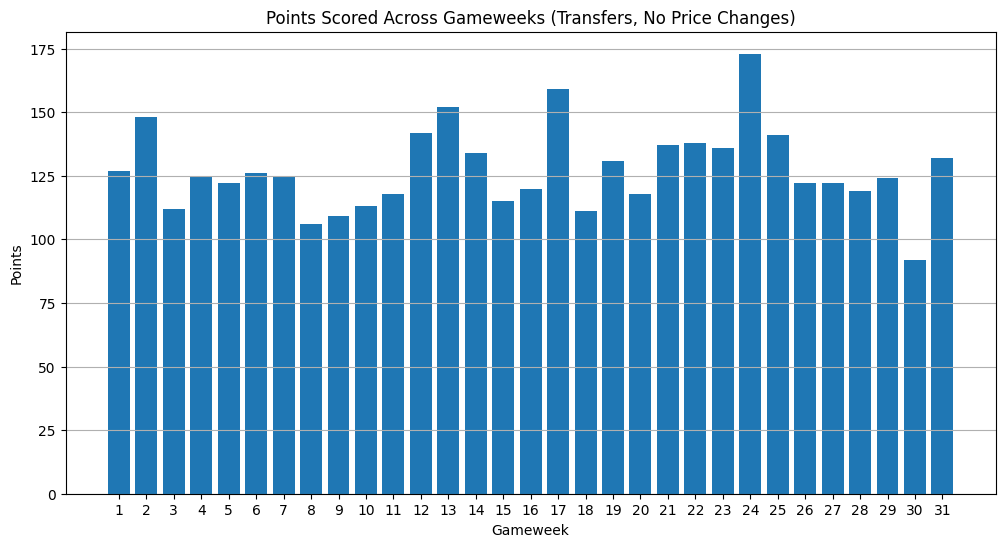

In [135]:
points_per_week = []
for gw in weeks:
    starting_in_gw = starting_df_transfers[["name", f"gw_{gw}"]].copy()
    starting_in_gw = starting_in_gw.merge(
        master_df[["name", f"gw_{gw}_points"]],
        on="name",
        how="left"
    )
    starting_in_gw["points"] = starting_in_gw[f"gw_{gw}"] * starting_in_gw[f"gw_{gw}_points"]
    if gw != 1:
      total_points = starting_in_gw["points"].sum() - 4 * transfer_count[transfer_count["gameweek"] == gw]["transfers"].values[0]
    else:
      total_points = starting_in_gw["points"].sum()
    points_per_week.append(total_points)

plt.figure(figsize=(12, 6))
plt.bar(weeks, points_per_week)

plt.xlabel("Gameweek")
plt.ylabel("Points")
plt.title("Points Scored Across Gameweeks (Transfers, No Price Changes)")
plt.xticks(weeks)
plt.grid(axis='y')
plt.show()

In [136]:
print("Points with Transfers, No Price Changes: " + str(sum(points_per_week)))

Points with Transfers, No Price Changes: 3949.0


In [145]:
transfer_count['transfers'].sum()*4

np.float64(492.0)

In [146]:
transfers_df['transfers'].sum()*4

np.float64(484.0)

In [120]:
def lin_opt_price_changes(df):
  model = pulp.LpProblem("FPL_All_Weeks_Price_Changes", pulp.LpMaximize)
  weeks = range(1, 32)
  players = list(df.index)

  x = {j: pulp.LpVariable.dicts(f"x_{j}", players, cat="Binary") for j in weeks}
  y = {j: pulp.LpVariable.dicts(f"y_{j}", players, cat="Binary") for j in weeks}
  cap = {j: pulp.LpVariable.dicts(f"cap_{j}", players, cat="Binary") for j in weeks}
  u = {j: pulp.LpVariable.dicts(f"u_{j}", players, cat="Binary") for j in range(2, 32)}
  p = {j: pulp.LpVariable(f"p_{j}", lowBound=0, cat="Integer") for j in range(2, 32)}
  M = {j: pulp.LpVariable(f"M_{j}", lowBound = 0) for j in weeks}

  model += (pulp.lpSum(pulp.lpSum(df.loc[i, f'gw_{j}_points'] * (y[j][i] + cap[j][i]) for i in players) for j in weeks)
  - pulp.lpSum(4 * p[j] for j in range(2, 32))), "Total_Points"

  for j in weeks:
    model += pulp.lpSum(x[j][i] for i in players) == 15
    if j == 1:
      model += pulp.lpSum(df.loc[i, f'gw_1_value'] * x[1][i] for i in players) <= 1000
    model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'position'] == "GK") == 2
    model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'position'] == "DEF") == 5
    model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'position'] == "MID") == 5
    model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'position'] == "FWD") == 3
    teams = df['team'].unique()
    for team in teams:
      model += pulp.lpSum(x[j][i] for i in players if df.loc[i, 'team'] == team) <= 3

    model += pulp.lpSum(y[j][i] for i in players) == 11
    model += pulp.lpSum(y[j][i] for i in players if df.loc[i, 'position'] == "GK") == 1
    model += pulp.lpSum(y[j][i] for i in players if df.loc[i, 'position'] == "DEF") >= 3
    model += pulp.lpSum(y[j][i] for i in players if df.loc[i, 'position'] == "MID") >= 2
    model += pulp.lpSum(y[j][i] for i in players if df.loc[i, 'position'] == "FWD") >= 1
    model += pulp.lpSum(cap[j][i] for i in players) == 1

    for i in players:
      model += y[j][i] <= x[j][i]
      model += cap[j][i] <= y[j][i]

  for j in range(2, 32):
    for i in players:
      model += u[j][i] >= x[j][i] - x[j-1][i]
      model += u[j][i] <= x[j][i]
      model += u[j][i] <= 1 - x[j-1][i]
    model += p[j] >= pulp.lpSum(u[j][i] for i in players) - 1

  model += M[1] == 1000 - pulp.lpSum(df.loc[i, f'gw_1_value'] * x[1][i] for i in players)
  for j in range(2, 32):
    model += M[j] == M[j-1] + pulp.lpSum(df.loc[i, f'gw_{j}_value'] * (x[j-1][i] - x[j][i]) for i in players)
    model += M[j] >= 0
  model.solve()

  players_in_any_squad = [i for i in players if any(x[j][i].varValue == 1 for j in weeks)]
  base_cols = df.loc[players_in_any_squad, ['name', 'position', 'team']].copy()

  squad_df = base_cols.copy()
  starting_df = base_cols.copy()

  for j in weeks:
    squad_col = []
    start_col = []
    for i in players_in_any_squad:
      squad_val = int(x[j][i].varValue)
      squad_col.append(squad_val)

      if cap[j][i].varValue == 1:
          start_col.append(2)
      elif y[j][i].varValue == 1:
          start_col.append(1)
      else:
          start_col.append(0)

    squad_df[f'gw_{j}'] = squad_col
    starting_df[f'gw_{j}'] = start_col

  bank_df = pd.DataFrame({
      "gameweek": list(weeks),
      "bank": [M[j].varValue for j in weeks]
  })

  transfers_df = pd.DataFrame({
      "gameweek": range(2, 32),
      "transfers": [p[j].varValue for j in range(2, 32)]
  })

  return squad_df, starting_df, bank_df, transfers_df

In [121]:
squad_df_prices, starting_df_prices, bank_df, transfers_df = lin_opt_price_changes(master_df_prices)

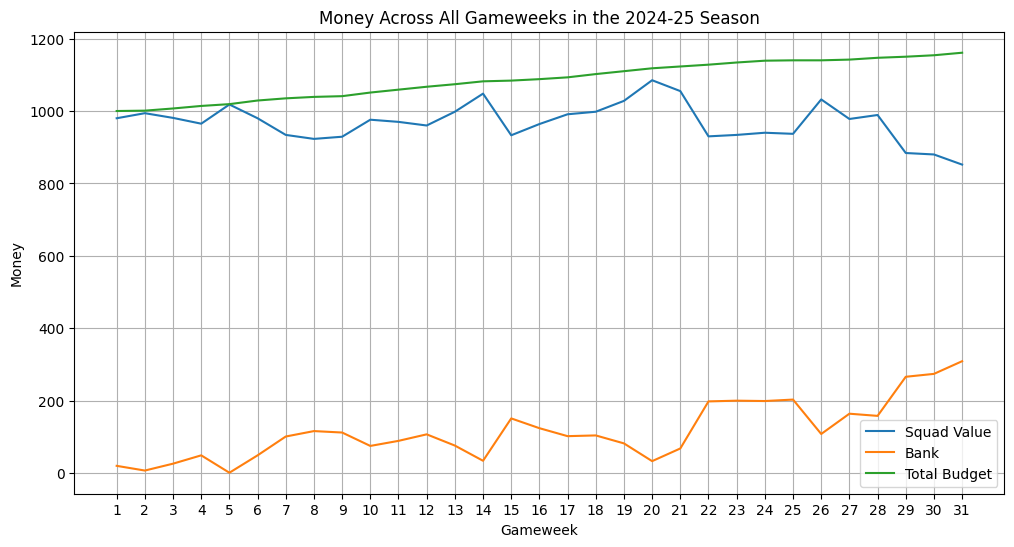

In [49]:
squad_values = []

for gw in weeks:
  squad_in_gw = squad_df_prices[["name", f"gw_{gw}"]].copy()
  squad_in_gw = squad_in_gw.merge(
    master_df_prices[["name", f"gw_{gw}_value"]],
    on="name",
    how="left"
  )
  squad_in_gw["value"] = squad_in_gw[f"gw_{gw}"] * squad_in_gw[f"gw_{gw}_value"]
  total_value = squad_in_gw["value"].sum()
  squad_values.append(total_value)

bank_values = bank_df["bank"].tolist()
total_budget = [s + b for s, b in zip(squad_values, bank_values)]

plt.figure(figsize=(12, 6))
plt.plot(weeks, squad_values, label="Squad Value")
plt.plot(weeks, bank_values, label="Bank")
plt.plot(weeks, total_budget, label="Total Budget")

plt.xlabel("Gameweek")
plt.ylabel("Money")
plt.title("Money Across All Gameweeks in the 2024-25 Season")
plt.xticks(weeks)
plt.grid(True)
plt.legend()
plt.show()

In [50]:
squad_df_prices['total_apps'] = squad_df_transfers[gw_columns].sum(axis=1)
starting_df_prices['total_starts'] = (starting_df_transfers[gw_columns] >= 1).sum(axis=1)

In [51]:
squad_df_prices[['name', 'position', 'team', 'total_apps']].sort_values(by='total_apps', ascending=False).head(8)

,name,position,team,total_apps
538,Matz Sels,GK,Nott'm Forest,20.0
388,Jordan Pickford,GK,Everton,19.0
599,Ola Aina,DEF,Nott'm Forest,17.0
559,Mohamed Salah,MID,Liverpool,17.0
770,William Saliba,DEF,Arsenal,16.0
145,Cole Palmer,MID,Chelsea,14.0
166,Daniel Muñoz,DEF,Crystal Palace,11.0
25,Alexander Isak,FWD,Newcastle,11.0


In [52]:
starting_df_prices[['name', 'position', 'team', 'total_starts']].sort_values(by='total_starts', ascending=False).head(8)

,name,position,team,total_starts
559,Mohamed Salah,MID,Liverpool,17.0
145,Cole Palmer,MID,Chelsea,10.0
136,Chris Wood,FWD,Nott'm Forest,9.0
25,Alexander Isak,FWD,Newcastle,9.0
388,Jordan Pickford,GK,Everton,9.0
599,Ola Aina,DEF,Nott'm Forest,8.0
770,William Saliba,DEF,Arsenal,8.0
102,Bryan Mbeumo,MID,Brentford,8.0


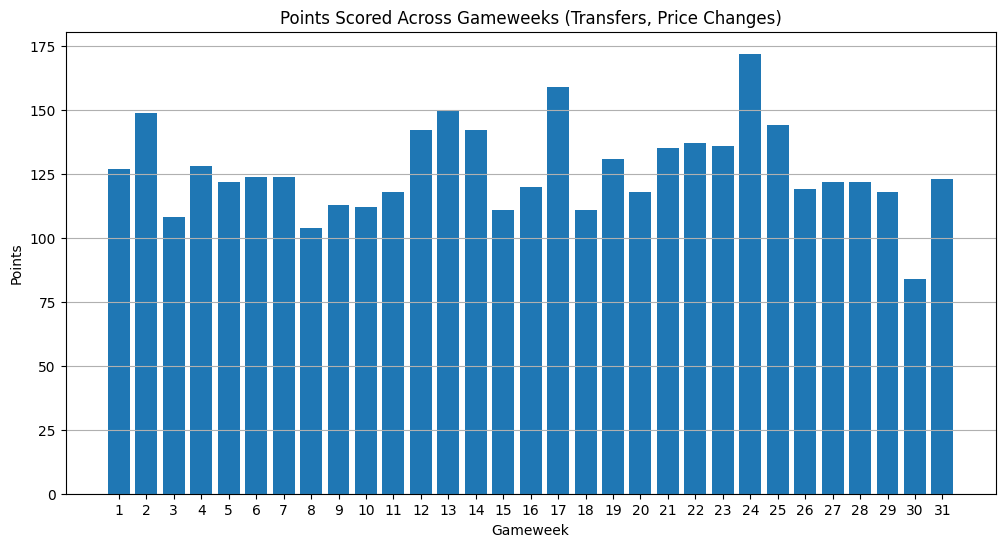

In [124]:
points_per_week = []
for gw in weeks:
    starting_in_gw = starting_df_prices[["name", f"gw_{gw}"]].copy()
    starting_in_gw = starting_in_gw.merge(
        master_df[["name", f"gw_{gw}_points"]],
        on="name",
        how="left"
    )
    starting_in_gw["points"] = starting_in_gw[f"gw_{gw}"] * starting_in_gw[f"gw_{gw}_points"]
    if gw != 1:
      total_points = starting_in_gw["points"].sum() - 4 * transfers_df[transfers_df["gameweek"] == gw]["transfers"].values[0]
    else:
      total_points = starting_in_gw["points"].sum()
    points_per_week.append(total_points)

plt.figure(figsize=(12, 6))
plt.bar(weeks, points_per_week)

plt.xlabel("Gameweek")
plt.ylabel("Points")
plt.title("Points Scored Across Gameweeks (Transfers, Price Changes)")
plt.xticks(weeks)
plt.grid(axis='y')
plt.show()

In [131]:
print("Points with Transfers and Price Changes: " + str(sum(points_per_week)))

Points with Transfers and Price Changes: 3925.0
